## Sandwich_profiles_from_xarray

This notebook explores processing profiles.

This is material copied from the end of Sandwich_analyze_ROI. These are experiments in processing transects, but don't run yet...they need the packages and data.

In [76]:
import numpy as np
import  json
from  shapely.geometry  import Polygon, Point
import shapely.ops as shops
#from descartes.patch import PolygonPatch
import shapely.vectorized
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import hvplot.xarray
import pandas as pd
from IPython.display import display, HTML
from scipy import interpolate, signal, stats
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

In [2]:
da = xr.open_dataarray('one_meter_test.nc')
(num_maps,ysize,xsize)=np.shape(da.values)
print('Shape of stacked elevation array: ',num_maps,xsize,ysize)

# use meshgrid to make coordinate arrays
X, Y = np.meshgrid( da.coords['Cross-shore'].values, da.coords['Alongshore'].values )
print('Shape of X and Y',np.shape(X),np.shape(Y))

Shape of stacked elevation array:  14 280 1300
Shape of X and Y (1300, 280) (1300, 280)


C:\Users\csherwood\AppData\Local\Continuum\Anaconda\envs\IOOS3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in greater


Slope:  0.0471332814973 Intercept:  -5.66937800359 r:  0.93942957617 p:  1.77619348885e-05 Stderr:  0.00573204388613
xrMWL:  120.283965459


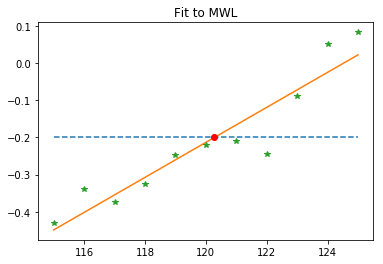

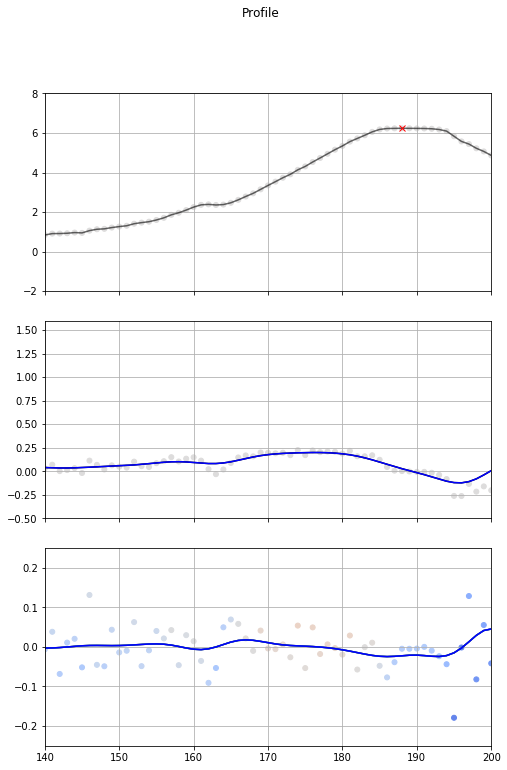

In [138]:

z = np.flip( da[0,680,:].values, 0 )
# z[z<-200.]=-200.
# smooth w/ Gausss or box
# box_kernel = Box1DKernel(5)
#  size of Gauss kernal
gkn = 3
#  amount to remove at ends
gkno2 = int(round(gkn/2.))
gauss_kernel = Gaussian1DKernel(gkn)
zf = convolve(np.array(z), gauss_kernel)
zip = np.array((0))
dzf =  np.diff( np.append(zip, zf) )
ddzf = np.diff( np.append(zip, dzf) )
ddzf[np.abs(ddzf)>0.1]=np.NaN

#unfilted derivatives
dz =  np.diff( np.append(zip, z) )
dz[np.abs(ddz)>20]=np.NaN

ddz = np.diff( np.append(zip, dz) )
ddz[np.abs(ddz)>20]=np.NaN

# filtered unfiltered derivatives
fdz = convolve(np.array(dz), gauss_kernel)
fddz = convolve(np.array(ddz), gauss_kernel)

# d(filter(dz))
dfdz = np.diff(np.append(zip,fdz))

#ddz = np.diff
#print(np.shape(z),np.shape(dz))
x = np.flip( da.coords['Cross-shore'].values, 0)
# reverse x-axis direction...now starts some arbitrary distance offshore
xr = np.max(x)-x

# find MWL by fitting line to nearby points
MWLdatum = -0.2
idx = np.argwhere(np.abs(zf-MWLdatum)<0.3)
#print("idx=",idx,xr[idx],z[idx])
#print(np.shape(idx),np.shape(z[idx]-MWLdatum))

slope, intercept, r_value, p_value, stderr = stats.linregress( np.squeeze(xr[idx]),np.squeeze(z[idx]-MWLdatum) )
# y = a+b*x
# x = 1/b * -a
xrMWL = 1./slope * -intercept
print("Slope: ",slope,"Intercept: ",intercept,"r: ",r_value,"p: ", p_value,"Stderr: ",stderr)
print("xrMWL: ",xrMWL)
plt.plot(xr[idx],np.zeros_like(xr[idx])+MWLdatum,'--')
plt.plot(xr[idx],xr[idx]*slope+intercept+MWLdatum,'-')
plt.plot(xr[idx],z[idx],'*')
plt.plot(xrMWL,MWLdatum,'or')
plt.title('Fit to MWL')

# find dhi
# find max of z
idhi = np.nanargmax(z)
dhi = z[idhi]
xdhi = xr[idhi]

xmin = 140
xmax = 200
cmap = 'coolwarm'
f, axarr = plt.subplots(3, sharex=True, figsize=(8,12) )
f.suptitle('Profile')
axarr[0].plot(xr, z, '-k', alpha = .6)
axarr[0].scatter(xr, z, 25, dz, cmap=cmap )
axarr[0].plot(xdhi,dhi,'xr')
axarr[0].set_ylim((-2,8))
axarr[0].set_xlim((xmin,xmax))
axarr[0].grid(True)

axarr[1].plot(xr, dzf,'-k')
axarr[1].plot(xr, fdz,'-b')
axarr[1].scatter(xr, dz,25,dz,cmap=cmap)
axarr[1].set_ylim((-.5,1.6))
axarr[1].set_xlim((xmin,xmax))
axarr[1].grid(True)

axarr[2].scatter(xr, ddz, 25, dz, cmap=cmap)
axarr[2].plot(xr, fddz,'-k')
axarr[2].plot(xr, ddzf)
axarr[2].plot(xr, dfdz,'-b')
axarr[2].set_ylim((-.25,.25))
axarr[2].set_xlim((xmin,xmax))
axarr[2].grid(True)

# Bring subplots close to each other.
f.subplots_adjust(hspace=0.15)
# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()

#print(i)
#for ii in range(-5,5):
#    print(i+ii,xr[i+ii],z[i+ii],zf[i+ii])

In [30]:
MWLdatum = -0.2
imap = 13
xik = np.ones((1300,1))*np.NaN
xikb = np.ones((1300,1))*np.NaN

# extract the x coords
x = da.coords['Cross-shore'].values
y = da.coords['Alongshore'].values
for itno in range(0,1300):
    # itno = 200

    # extract a transect
    t = np.flip(np.array(da[0,itno,:]),0)

    idx = np.where(t<-100.)
    t[idx]=-10.

    # smooth w/ box (omit later?)
    box_kernel = Box1DKernel(5)
    tsb = convolve(np.array(t), box_kernel)

    # smooth w/ Gauss
    #  size of kernal
    gkn = 5
    #  amount to remove at ends
    gkno2 = int(round(gkn/2.))
    gauss_kernel = Gaussian1DKernel(gkn)
    tsg = convolve(np.array(t), gauss_kernel)
    # NaN the ends?
    # tsg[0:gkno2]=np.NaN
    # tsg[-(gkno2+1):-1]=np.NaN

    # calculate gradients (add a value to keep arrays same length)
    dts = np.append([0.],np.diff(tsg))
    ddts = np.append([1.],np.diff(dts))
    dddts = np.append([1.],np.diff(ddts))

    # look for shoreline
    #   postitive slope
    pos_slope = dts>=5e-5
    #   close to MWL
    close = np.abs(t-(-1.))<=0.05
    xlimit = x<150.
    kdx = np.logical_and( np.logical_and(close, pos_slope), xlimit)
    kdx1 = np.argmax(kdx)
    xik[itno]=x[kdx1]
    
    # look for back of barrier
    neg_slope = dts<=-5e-5
    xextend = x>(xik[itno]+100.)
    #print(sum(neg_slope),sum(xextend))
    kdxb = np.logical_and( np.logical_and(close, neg_slope), xextend )
    kdx2 = np.argmax(kdxb)
    #print('x[kdx2], t[kdx2] =',x[kdx2],t[kdx2]-MWLdatum)
    xikb[itno]=x[kdx2]
    #print(itno,': found ',np.sum(kdxb),' first one:', kdx2)



C:\Users\csherwood\AppData\Local\Continuum\Anaconda\envs\IOOS3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in less
C:\Users\csherwood\AppData\Local\Continuum\Anaconda\envs\IOOS3\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in less_equal
C:\Users\csherwood\AppData\Local\Continuum\Anaconda\envs\IOOS3\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\csherwood\AppData\Local\Continuum\Anaconda\envs\IOOS3\lib\site-packages\ipykernel\__main__.py:49: RuntimeWarning: invalid value encountered in less_equal


In [ ]:
from scipy.ndimage.filters import maximum_filter1d, median_filter
xikf = np.zeros_like(xik)
median_filter(xik, 21, output=xikf, mode='nearest')
# try several filters...use the biggest values
xikbf7= np.ones_like(xik)
xikbf21= np.ones_like(xik)
xikbf51= np.ones_like(xik)

median_filter(xikb, 7, output=xikbf7, mode='nearest')
median_filter(xikb, 21, output=xikbf21, mode='nearest')
median_filter(xikb, 51, output=xikbf51, mode='nearest')
xikbf = np.max((np.hstack((xikbf7,xikbf21,xikbf51))),axis=1)

plt.plot(xik)
plt.plot(xikf,'.k')
plt.plot(xikb,'-b')
plt.plot(xikbf,'.c')
plt.xlim(400, 600)

In [ ]:
da.isel(map=imap).plot(vmin=-2,vmax=8,cmap=plt.cm.terrain)
plt.plot(280-xikf,y,'or')
plt.plot(180-xikf,y,'og')
plt.plot(280-xikbf,y,'oy')

In [ ]:
#   first point of points closest to MWL elevation (this does not work if an inland one is closer)
# mlw =  np.argmin(np.abs(t-MWLdatum))

fig, ax = plt.subplots()
plt.plot(x,np.zeros_like(x),'--k')
plt.plot(x,t,label='Data')
plt.plot(x,tsg,label='Gauss')
# plt.plot(x,tsb,label='Box')
plt.plot(x,10*dts)
#plt.plot(x,10*ddts)
plt.plot(x[kdx],t[kdx],'ok',label='MLW')
#plt.plot(x[mlwg],t[mlwg],'ob')
ax.legend()